In [11]:
# Import packages
import os
import optuna
from graphviz import Digraph
from optuna.storages import JournalFileStorage, JournalStorage
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np

In [12]:
num_nodes = 2
study_name = f"dcl_{num_nodes}"
optuna_dir = f"optuna/{study_name}"
transforms = "DINO"
storage = JournalStorage(JournalFileStorage(os.path.join(optuna_dir, "optuna.log")))
study = optuna.create_study(
    storage=storage,
    study_name=study_name,
    load_if_exists=True,
)

/tmp/ipykernel_3677860/1534619840.py:5: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = JournalStorage(JournalFileStorage(os.path.join(optuna_dir, "optuna.log")))
[I 2024-05-29 16:37:00,785] Using an existing study with name 'dcl_2' instead of creating a new one.


In [13]:
study_df = study.trials_dataframe()
complete_df = study_df[study_df.state == "COMPLETE"]
sorted_df = complete_df.sort_values(by="value", ascending=False)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
from torch import nn
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

class PositiveGammaGate(nn.Module):
    def __init__(self, max_epoch, gamma):
        super(PositiveGammaGate, self).__init__()
        self.max_epoch = max_epoch
        self.gamma = gamma

    def forward(self, loss, epoch):
        loss_weight = epoch / self.max_epoch
        loss_weight = loss_weight ** (1 / self.gamma)
        loss *= loss_weight
        return loss

    def weight_change(self, epoch):
        loss_weight = epoch / self.max_epoch
        return loss_weight ** (1 / self.gamma)

class NegativeGammaGate(nn.Module):
    def __init__(self, max_epoch, gamma):
        super(NegativeGammaGate, self).__init__()
        self.max_epoch = max_epoch
        self.gamma = gamma

    def forward(self, loss, epoch):
        loss_weight = (self.max_epoch - epoch) / self.max_epoch
        loss_weight = loss_weight ** (1 / self.gamma)
        loss *= loss_weight
        return loss

    def weight_change(self, epoch):
        loss_weight = (self.max_epoch - epoch) / self.max_epoch
        return loss_weight ** (1 / self.gamma)

def extract_scalar_arrays(scalar_events):
    wall_times = []
    steps = []
    values = []

    for event in scalar_events:
        wall_times.append(event.wall_time)
        steps.append(event.step)
        values.append(event.value)

    return np.array(wall_times), np.array(steps), np.array(values)

def get_node_name(top_series, model_id, models, ssls, gate_names_list):
    accumulator = EventAccumulator(
        f"runs/{study_name}/{transforms}/{top_series.number:04}/{model_id}_{top_series[models[model_id]]}_{top_series[ssls[model_id]]}/"
    )
    accumulator.Reload()
    _, _, values = extract_scalar_arrays(accumulator.Scalars("test_top1"))
    gate_name = top_series[f"params_{model_id}_{model_id}_gate"]
    if gate_name == "CutoffGate" and not all(
        gate_name == "CutoffGate" for gate_name in gate_names_list[model_id]
    ):
        node_name = f"{model_id+1}. {top_series[models[model_id]]}"
    else:
        node_name = f"{model_id+1}. {top_series[models[model_id]]}\n{top_series[ssls[model_id]]}"
    node_name += f"\n{max(values):.2f}%"
    return node_name

def get_edge_color(gate_name):
    return {"PositiveGammaGate": "4", "NegativeGammaGate": "2"}[gate_name]

def plot_weight_changes(gate, max_epoch, num):
    epochs = range(max_epoch)
    weight_changes = [gate.weight_change(epoch) for epoch in epochs]
    plt.figure(figsize=(3, 3))
    if "Positive" in gate.__class__.__name__:
        plt.plot(epochs, weight_changes, label=f'Gamma: {gate.gamma:.2f}', color='green')
    else:
        plt.plot(epochs, weight_changes, label=f'Gamma: {gate.gamma:.2f}')
    plt.xlabel('Epoch')
    plt.ylabel('Weight')
    plt.legend()
    plt.grid(True)
    file_name = f"{gate.__class__.__name__}_{num}.svg"
    plt.savefig(file_name, bbox_inches='tight')
    plt.close()
    return file_name

def create_graph(sorted_df, top):
    top_series = sorted_df.iloc[top]
    models = sorted(list(filter(lambda x: "model" in x, top_series.keys())))
    ssls = sorted(list(filter(lambda x: "ssl" in x, top_series.keys())))

    excluded_nodes = []
    while True:
        gate_names_list = [
            [
                top_series[f"params_{j}_{model_id}_gate"]
                for j, _ in enumerate(models)
                if model_id != j and j not in excluded_nodes
            ]
            for model_id, _ in enumerate(models)
        ]
        new_excluded_nodes = [
            model_id
            for model_id, gate_names in enumerate(gate_names_list)
            if all(gate_name == "CutoffGate" for gate_name in gate_names)
        ]
        if len(excluded_nodes) == len(new_excluded_nodes):
            break
        excluded_nodes = new_excluded_nodes

    gate_names_list = [
        [top_series[f"params_{model_id}_{j}_gate"] for j, _ in enumerate(models)]
        for model_id, _ in enumerate(models)
    ]

    graph = Digraph(format="svg")
    for model_id, _ in enumerate(models):
        if model_id in excluded_nodes:
            continue
        node_color = "pink" if model_id == 0 else "gray90"
        node_name = get_node_name(top_series, model_id, models, ssls, gate_names_list)
        graph.node(node_name, color=node_color, fillcolor=node_color, style="filled")

        for j, _ in enumerate(models):
            gate_name = top_series[f"params_{model_id}_{j}_gate"]
            loss_name = top_series[f"params_{model_id}_{j}_loss"]
            if gate_name == "CutoffGate" or loss_name == "SSLLoss":
                continue
            gamma = top_series[f"params_{model_id}_{j}_gamma"]
            neighbor_node_name = get_node_name(
                top_series, j, models, ssls, gate_names_list
            )
            edge_color = get_edge_color(gate_name)
            if gate_name == "PositiveGammaGate":
                gate = PositiveGammaGate(800, gamma)
            else:
                gate = NegativeGammaGate(800, gamma)
            weight_change_plot = plot_weight_changes(gate, 800, f"{model_id}_{j}")
            
            graph.edge(
                neighbor_node_name,
                node_name,
                label=f"<<TABLE BORDER='0'><TR><TD><IMG SRC='{weight_change_plot}'/></TD></TR></TABLE>>",
                fontsize="13",
                fontcolor=edge_color,
                color=edge_color,
                colorscheme="paired12",
            )

        if all(gate_name == "CutoffGate" for gate_name in gate_names_list[model_id]):
            graph.node(
                node_name, color="lightblue", fillcolor="lightblue", style="filled"
            )
    return graph


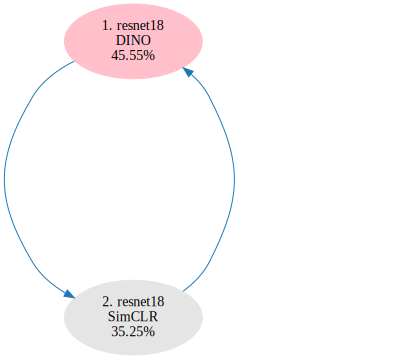

In [17]:
top = 3
G = create_graph(study_df, top)
display(G)